In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [5]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 4)

In [6]:
len(data_tr[2])

54490

In [7]:
len(data_te_tr[2])

27136

In [8]:
len(data_te_vl[2])

6426

In [9]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [10]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
# train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
#                           batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each


In [11]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20240713T172026/reasoner.pt'))

<All keys matched successfully>

In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.7203 | val loss 0.7206 | acc 0.2125 | f1 0.3505 | prec 0.2125 | recall 0.9994 | roc auc 0.5276 | pr auc 0.2303 | elapsed 18.49s
train epoch 01/10 | batch 1704/1703 | loss 0.5887 | val loss 0.5075 | acc 0.7977 | f1 0.1010 | prec 0.9119 | recall 0.0535 | roc auc 0.5887 | pr auc 0.3263 | elapsed 32.56s
train epoch 02/10 | batch 1704/1703 | loss 0.4513 | val loss 0.4798 | acc 0.8014 | f1 0.2443 | prec 0.6388 | recall 0.1510 | roc auc 0.7002 | pr auc 0.4375 | elapsed 35.94s
train epoch 03/10 | batch 1704/1703 | loss 0.3392 | val loss 0.4876 | acc 0.8107 | f1 0.3945 | prec 0.6164 | recall 0.2901 | roc auc 0.7380 | pr auc 0.5131 | elapsed 32.27s
train epoch 04/10 | batch 1704/1703 | loss 0.2571 | val loss 0.5076 | acc 0.8187 | f1 0.4688 | prec 0.6218 | recall 0.3762 | roc auc 0.7498 | pr auc 0.5529 | elapsed 31.43s
train epoch 05/10 | batch 1704/1703 | loss 0.2085 |

In [12]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 1.0074 | val loss 1.0325 | acc 0.6659 | f1 0.3578 | prec 0.2978 | recall 0.4479 | roc auc 0.6225 | pr auc 0.3759 | elapsed 7.88s
train epoch 01/10 | batch 849/848 | loss 0.8721 | val loss 0.9117 | acc 0.6948 | f1 0.3697 | prec 0.3238 | recall 0.4307 | roc auc 0.6480 | pr auc 0.4016 | elapsed 13.92s
train epoch 02/10 | batch 849/848 | loss 0.6212 | val loss 0.8245 | acc 0.7247 | f1 0.3919 | prec 0.3621 | recall 0.4270 | roc auc 0.6716 | pr auc 0.4279 | elapsed 12.02s
train epoch 03/10 | batch 849/848 | loss 0.4466 | val loss 0.7665 | acc 0.7456 | f1 0.4112 | prec 0.3960 | recall 0.4277 | roc auc 0.6917 | pr auc 0.4525 | elapsed 11.95s
train epoch 04/10 | batch 849/848 | loss 0.3337 | val loss 0.7292 | acc 0.7631 | f1 0.4359 | prec 0.4314 | recall 0.4404 | roc auc 0.7073 | pr auc 0.4744 | elapsed 11.72s
train epoch 05/10 | batch 849/848 | loss 0.2632 | val loss 0.7051 | acc 0.7747 | f1 0.4511 | prec 0.4566 | recall 0.4457 | roc au

In [13]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

             mean       std     micro
acc      0.813915  0.051096  0.813451
prec     0.591420  0.149075  0.557403
recall   0.527353  0.101861  0.523031
f1       0.539918  0.066820  0.539670
auc_roc  0.783943  0.056686  0.775873
auc_pr   0.616911  0.085483  0.592375


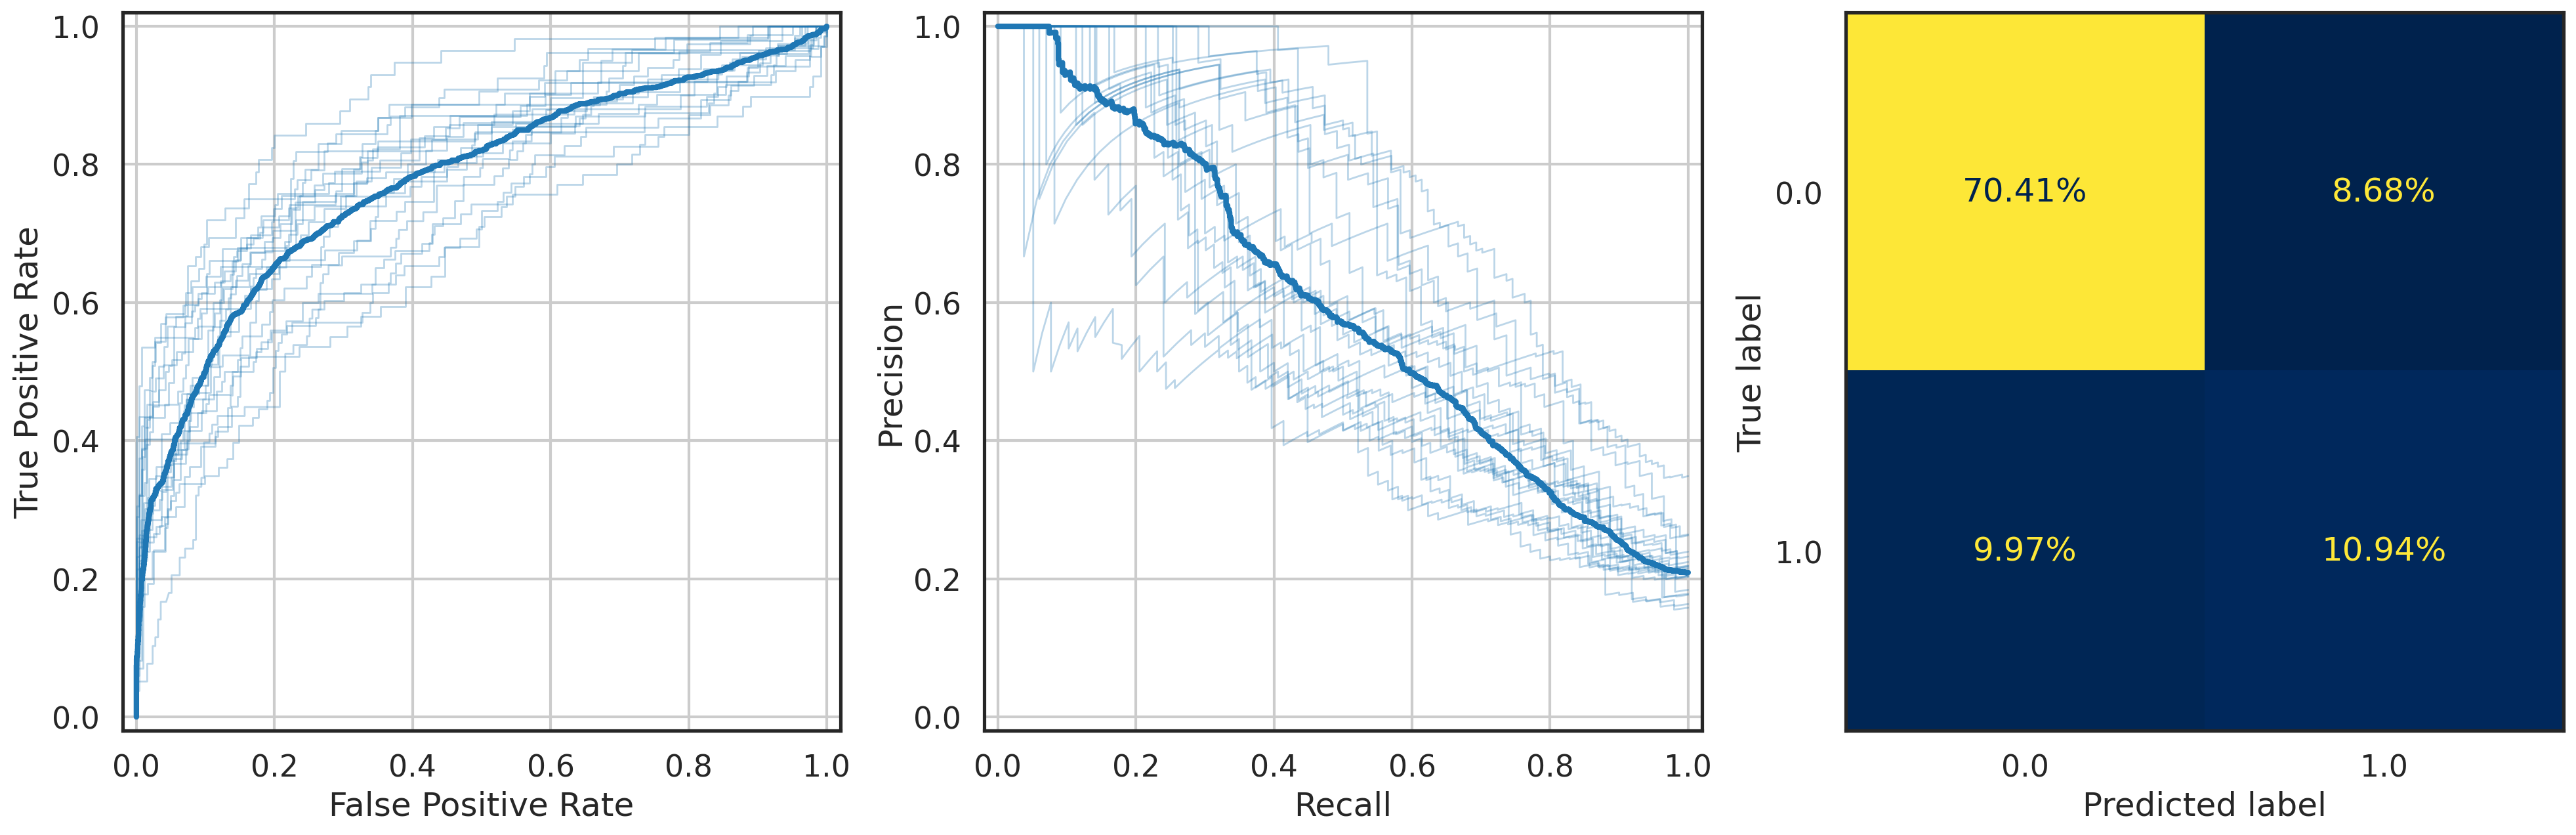

In [15]:
# base = 'local/out/exp/' + ts
# mkdirp(base)
# print(base)

# T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

# test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
# test_history = pd.DataFrame(test_logger.history_vl)
# test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
# test_history.to_csv(base+'/test.csv', index=False)
# test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
# test_results.to_csv(base+'/test-results.csv', index=False)
# plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [16]:
import random

In [17]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [18]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [19]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])

Double Negation:
  Mean Loss: 0.238014
  Std Dev Loss: 0.034402
  Mean Diff: 0.534282
  Std Dev Diff: 0.103704

Duality of Top and Bottom:
  Mean Loss: 0.363315
  Std Dev Loss: 0.000000
  Mean Diff: 0.737647
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.132017
  Std Dev Loss: 0.040196
  Mean Diff: 0.310536
  Std Dev Diff: 0.096493

Associativity:
  Mean Loss: 0.055640
  Std Dev Loss: 0.037674
  Mean Diff: 0.105579
  Std Dev Diff: 0.050046

Commutativity:
  Mean Loss: 0.037748
  Std Dev Loss: 0.012979
  Mean Diff: 0.089028
  Std Dev Diff: 0.030525

Contradiction:
  Mean Loss: 0.434609
  Std Dev Loss: 0.017461
  Mean Diff: 0.894493
  Std Dev Diff: 0.058615

Identity with Top:
  Mean Loss: 0.173497
  Std Dev Loss: 0.038501
  Mean Diff: 0.465288
  Std Dev Diff: 0.127318

Absorption by Bottom:
  Mean Loss: 0.621764
  Std Dev Loss: 0.029861
  Mean Diff: 1.304239
  Std Dev Diff: 0.083360

Top Concept Subsumption:
  Mean Loss: 0.004322
  Std Dev Loss: 0.003731
  Mean Diff: N/A
  Std De